# Generation of synthetic data


In [17]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt



### Question 1 : open data

In [18]:
with open('x.txt', 'r') as fichier:
    x = [float(nombre) for nombre in fichier.read().split()]
 

### Question 2 : create T using an exponential sampling strategy

In [19]:
N = 200
Tmin = 1
Tmax = 1000
T = []
for i in range(1, N+1):
    t = Tmin * np.exp(-(i-1)*(np.log(Tmin/Tmax)/(N-1)))
    T.append(t)





### Question 3 : Display the original signal x as a function of T (use log scale on the horizontal axis)

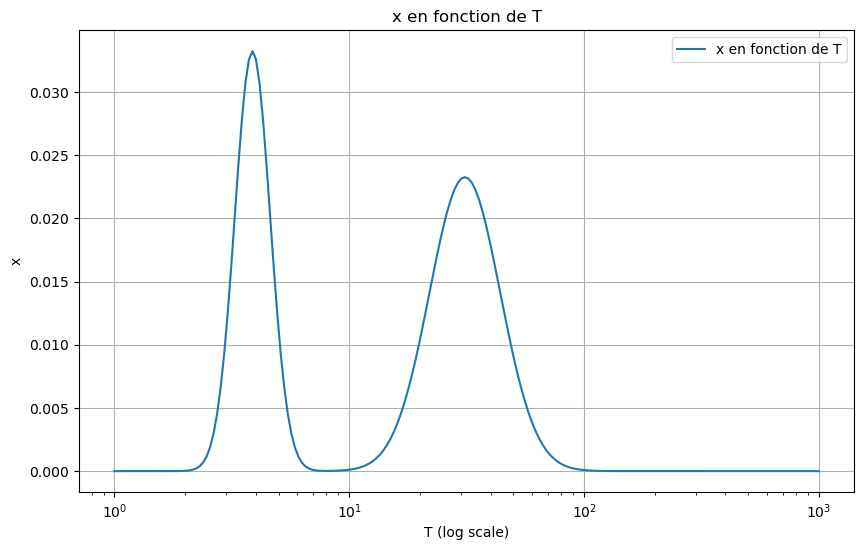

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(T, x, linestyle='-', label='x en fonction de T')
plt.xlabel("T (log scale)")
plt.ylabel("x")
plt.grid()
plt.title("x en fonction de T")
plt.legend()
plt.xscale('log')

# Afficher le graphique
plt.show()

### Question 4 :  Create t using a regular sampling strategy

In [21]:
M = 50
t_min = 0
t_max = 1.5
t_m = t_min + (np.arange(1, M + 1) - 1) / (M - 1) * (t_max - t_min)


### Question 5 :  Construct matrix K

In [22]:
K = np.exp(-np.outer(t_m, T))


### Question 6 : simulate noisy data

In [23]:
z = np.dot(K,x)
sigma = 0.01 * z[0]
w = np.random.multivariate_normal(np.zeros(M), sigma**2*np.identity(M))
y = z + w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


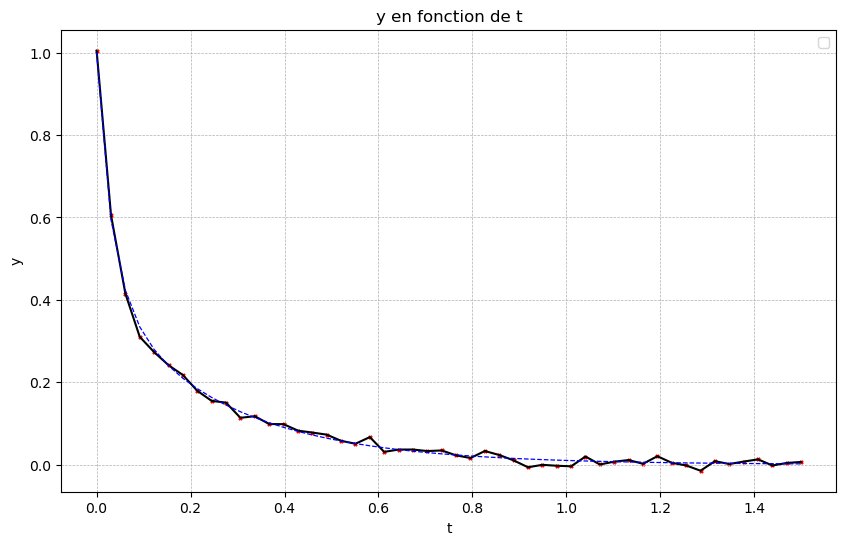

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(t_m, y, color = "black")
plt.plot(t_m, z, color = "blue", linestyle="--", linewidth=0.9)


plt.scatter(t_m, y, color = "red", s = 5, marker = "x")
plt.xlabel("t")
plt.ylabel("y")
plt.title("y en fonction de t")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Afficher le graphique
plt.show()

# Partie II:

##  Implémentation de l'algorithme Forward-Backward

In [55]:
import numpy as np
from scipy.special import lambertw

# Définition du gradient de f(x)
def grad_f(x, K, y):
    return K.T @ (K @ x - y)

# Définition du proximal operator pour l'entropie
def prox_ent(v, beta):
    x_prox = np.zeros_like(v)
    for n in range(len(v)):
        if v[n] <= 0:
            x_prox[n] = 0
        else:
            u = (v[n] / (beta)) - 1 + np.log(1/beta)
            if u > 100: # estimation pour des grands u
                w = u - np.log(u)
            else:
                w = lambertw(np.exp(u))
            
            x_prox[n] = beta * np.real(w)
    return x_prox


beta = 0.01     # Paramètre de régularisation
gamma = 1 / np.linalg.norm(K, ord=2)**2  # Pas basé sur la norme spectrale


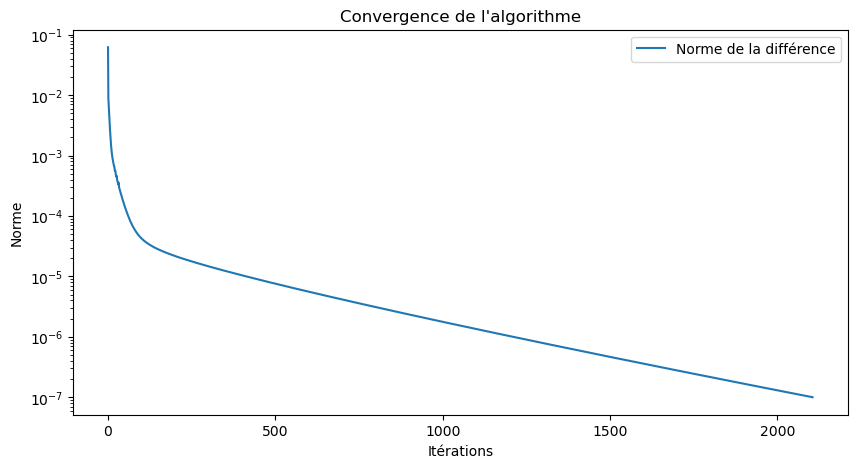

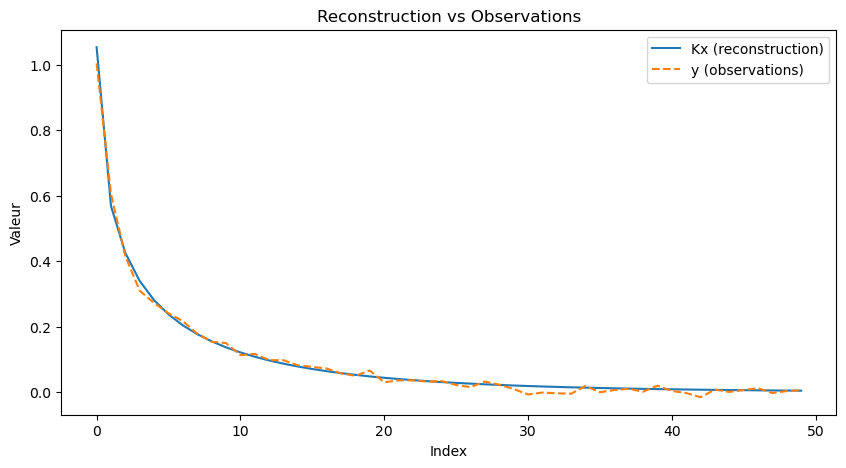

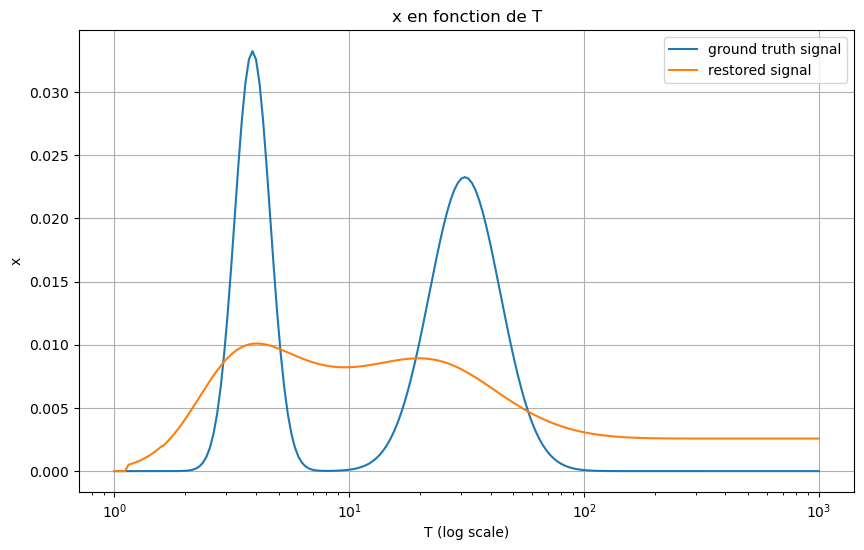

In [ ]:

import matplotlib.pyplot as plt
lamb = 1
def forward_backward(K, y, beta, gamma, max_iter=50000, tol=1e-7):
    N = K.shape[1]
    x = np.zeros(N)  # Initialisation
    residuals = []  # Stocke la norme de la différence
    for t in range(max_iter):
        z = x - gamma * grad_f(x, K, y) # Forward step
        x_new = x + lamb * (prox_ent(z, gamma * beta)-x) # Backward step
        residuals.append(np.linalg.norm(x_new - x))
        if residuals[-1] < tol:
            break
        x = x_new
    return x, residuals

x_hat, residuals = forward_backward(K, y, beta, gamma)

# Visualisation de la convergence
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Norme de la différence")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Norme")
plt.title("Convergence de l'algorithme")
plt.legend()
plt.show()

# Comparaison entre Kx et y
plt.figure(figsize=(10, 5))
plt.plot(K @ x_hat, label="Kx (reconstruction)")
plt.plot(y, label="y (observations)", linestyle="dashed")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.title("Reconstruction vs Observations")
plt.legend()
plt.show()


# Afficher le signal original et le signal reconstruit
plt.figure(figsize=(10, 6))
plt.plot(T, x, linestyle='-', label='ground truth signal')
plt.plot(T, x_hat, linestyle='-', label='restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("x en fonction de T")
plt.grid()
plt.legend()
plt.show()


## Implémentation de l'algorithme Douglas-Rachford

In [57]:
import numpy as np

def prox_f(z, lambda_):
    # Calcul des matrices nécessaires
    n = K.shape[1]
    KtK = K.T @ K
    I = np.eye(n)
    A = KtK + (1 / lambda_) * I
    b = K.T @ y + (1 / lambda_) * z
    
    # Résolution du système linéaire Ax = b
    prox = np.linalg.solve(A, b)
    
    return prox


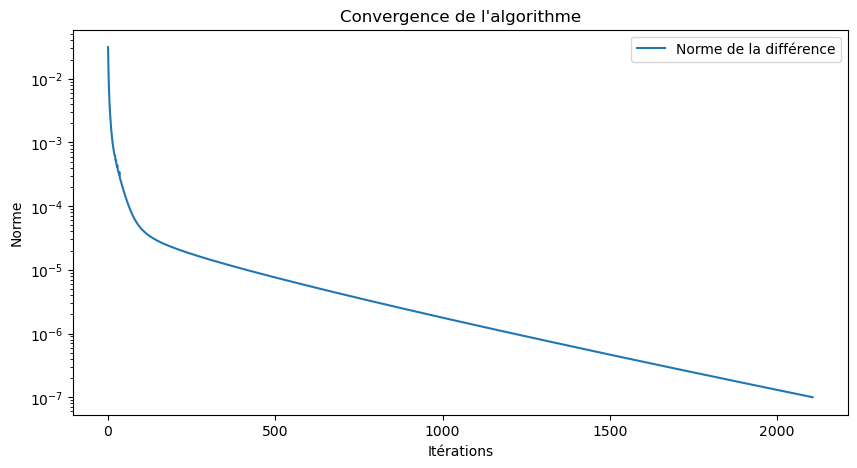

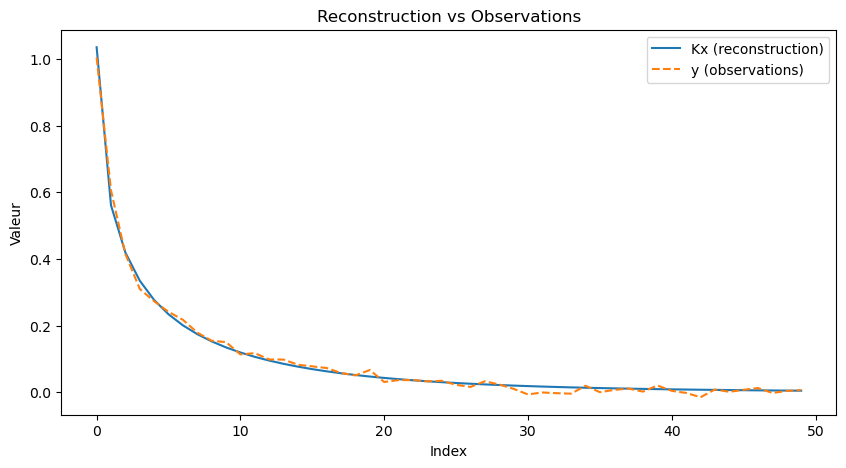

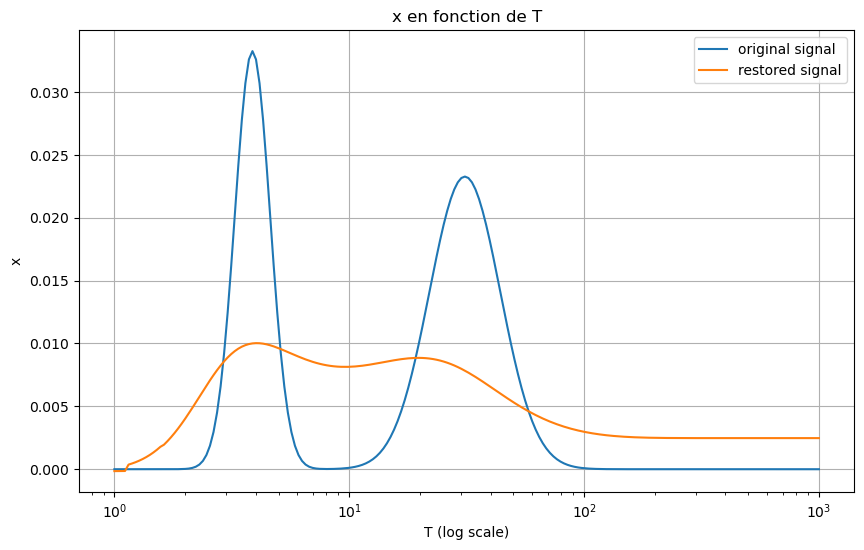

In [58]:
import matplotlib.pyplot as plt
lamb = 1
def douglas_rachford(K, y, beta, gamma, max_iter=50000, tol=1e-7):
    N = K.shape[1]
    x = np.zeros(N)  # Initialisation
    residuals = []  # Stocke la norme de la différence
    for t in range(max_iter):

        y = prox_ent(x, beta*gamma)
        z = prox_f(2*y - x, gamma)
        x_new = x + lamb * (z - y)
        residuals.append(np.linalg.norm(x_new - x))
        if residuals[-1] < tol:
            break
        x = x_new
    return x, residuals

# Exécuter avec suivi
x_hat, residuals = douglas_rachford(K, y, beta, gamma)

# Visualisation de la convergence
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Norme de la différence")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Norme")
plt.title("Convergence de l'algorithme")
plt.legend()
plt.show()

# Comparaison entre Kx et y
plt.figure(figsize=(10, 5))
plt.plot(K @ x_hat, label="Kx (reconstruction)")
plt.plot(y, label="y (observations)", linestyle="dashed")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.title("Reconstruction vs Observations")
plt.legend()
plt.show()


# Display the result
plt.figure(figsize=(10, 6))
plt.plot(T, x, linestyle='-', label='original signal')
plt.plot(T, x_hat, linestyle='-', label='restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("x en fonction de T")
plt.grid()
plt.legend()
plt.show()

## Choosing a better Beta 

In [71]:
def quadratic_error(l1, l2):
    error = sum((x - y) ** 2 for x, y in zip(l1, l2))
    return error

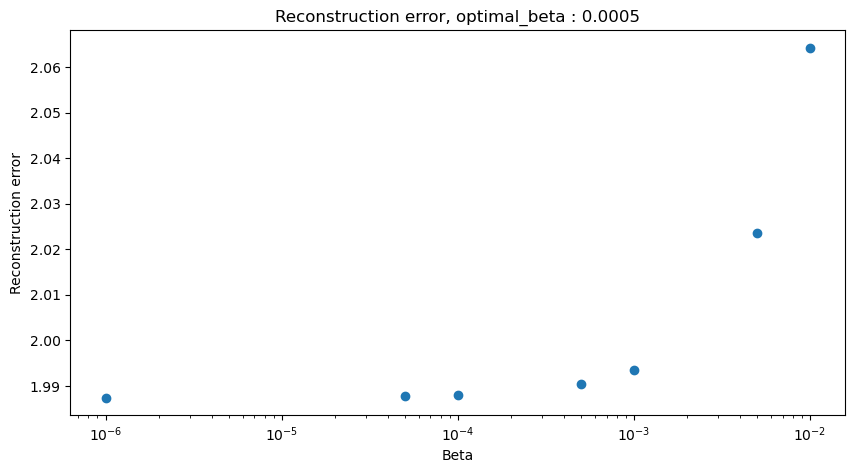

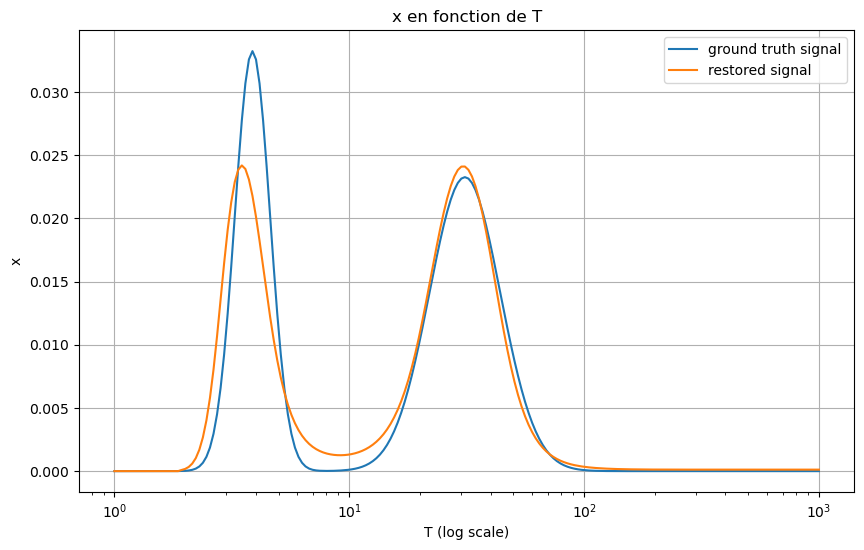

In [92]:

beta = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.000001]  

errors = []
for b in beta:
    x_hat, residuals = forward_backward(K, y, b, gamma, max_iter=10000)
    error  = quadratic_error(K @ x_hat, x)
    errors.append(error)


optimal_beta = 0.0005

x_hat, _ = forward_backward(K, y, optimal_beta, gamma, max_iter=50000)



# Erreur de reconstruction
plt.figure(figsize=(10, 5))
plt.scatter(beta, errors, label="reconstruction error")
plt.xlabel("Beta")
plt.xscale("log")
plt.ylabel("Reconstruction error")
plt.title(f"Reconstruction error, optimal_beta : {optimal_beta}")
plt.show()


# Afficher le signal original et le signal reconstruit
plt.figure(figsize=(10, 6))
plt.plot(T, x, linestyle='-', label='ground truth signal')
plt.plot(T, x_hat, linestyle='-', label='restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("x en fonction de T")
plt.grid()
plt.legend()
plt.show()

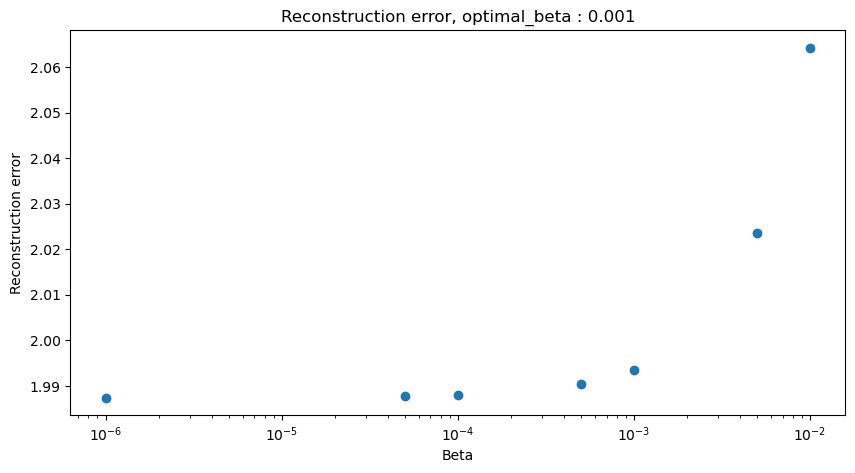

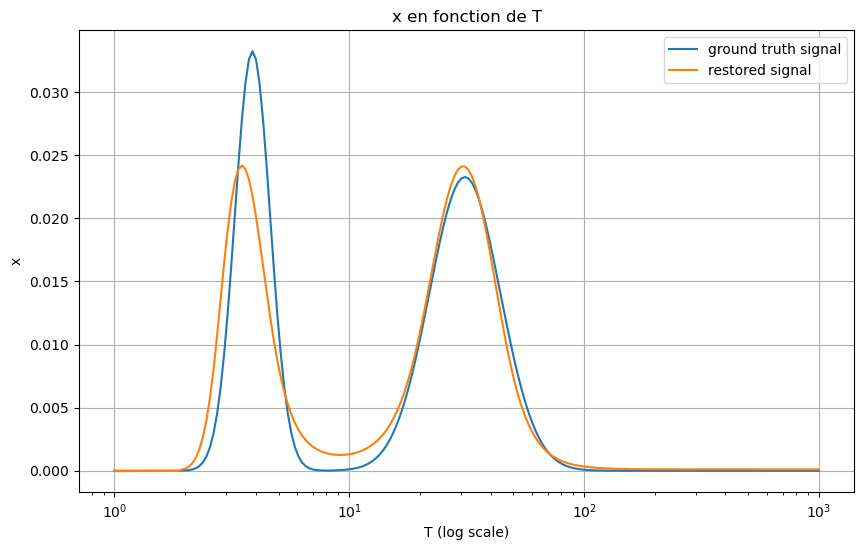

In [93]:
beta = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.000001]  

errors = []
for b in beta:
    x_hat, residuals = forward_backward(K, y, b, gamma, max_iter=10000)
    error  = quadratic_error(K @ x_hat, x)
    errors.append(error)

x_hat, _ = douglas_rachford(K, y, optimal_beta, gamma, max_iter=50000)

optimal_beta = 0.001

# Erreur de reconstruction
plt.figure(figsize=(10, 5))
plt.scatter(beta, errors, label="reconstruction error")
plt.xlabel("Beta")
plt.xscale("log")
plt.ylabel("Reconstruction error")
plt.title(f"Reconstruction error, optimal_beta : {optimal_beta}")
plt.show()


# Afficher le signal original et le signal reconstruit
plt.figure(figsize=(10, 6))
plt.plot(T, x, linestyle='-', label='ground truth signal')
plt.plot(T, x_hat, linestyle='-', label='restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("x en fonction de T")
plt.grid()
plt.legend()

## Constrained Algorithm 

In [108]:
# Entropy gradient
def entropy_gradient(x):
    if x.all()>0:
        return np.log(x)+1
    else:
        return ValueError("x must be positive")
    
def gradient(x):
    return entropy_gradient(x) + 2 * K.T @ (K @ x - y) 

In [130]:
def projection(x, eta, sigma_squared, max_iter=200, tol=1e-6, lr=0.01):
    """Project x onto the constraint set {z | ||Kz - y||^2 <= eta * M * sigma^2} using gradient descent."""
    def objective(z):
        return np.linalg.norm(K @ z - y) ** 2 - eta * K.shape[0] * sigma_squared
    def gradient(z):
        return 2 * K.T @ (K @ z - y)
    z = x.copy()
    for _ in range(max_iter):
        grad = gradient(z)
        z = z - lr * grad
        # Check if the constraint is satisfied
        if objective(z) <= 0:
            return z
        # Stop if gradient is small enough
        if np.linalg.norm(grad) < tol:
            break

    # Return the final z after iterations
    return z

/var/folders/5n/frcvwtwx4mq65rbl8_j55wfh0000gn/T/ipykernel_68039/1856298886.py:6: RuntimeWarning: overflow encountered in matmul
  return 2 * K.T @ (K @ z - y)
/var/folders/5n/frcvwtwx4mq65rbl8_j55wfh0000gn/T/ipykernel_68039/1856298886.py:10: RuntimeWarning: invalid value encountered in subtract
  z = z - lr * grad


Reached maximum iterations.


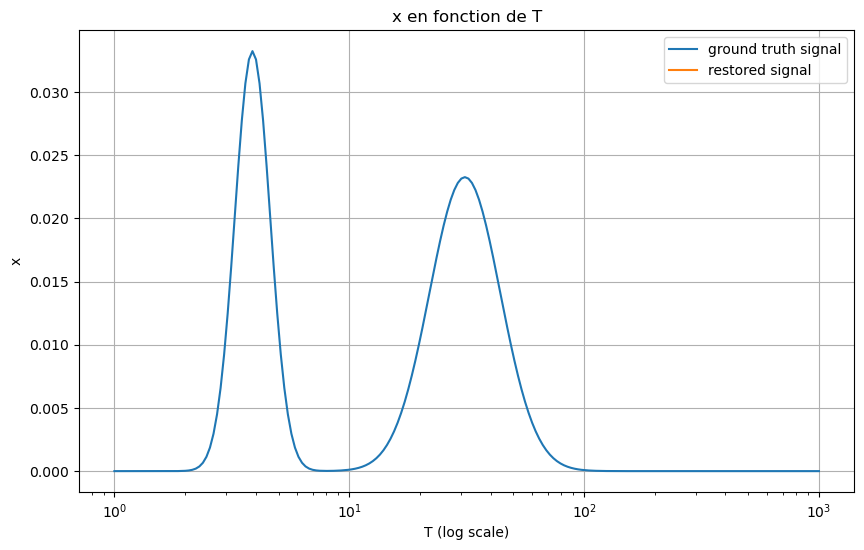

In [131]:
def projected_gradient(gamma,  max_iter=50000, tol = 1e-10, eta=1.0, sigma_squared=sigma**2):
    
    N = K.shape[1]
    x = np.ones(N) * 1e-3

    for t in range(max_iter):
        # Gradient descent step
        step = x - gamma * entropy_gradient(x)

        # Projection onto the feasible set
        x_next = projection(step, eta, sigma_squared)

        # Check for convergence
        # if np.sqrt(np.sum((x_next - x) ** 2)) < tol:
        #     print(f"Converged in {t} iterations.")
        #     return x_next

        x = x_next

    print("Reached maximum iterations.")
    return x

x_hat = projected_gradient(gamma=0.05, max_iter=1000)

# Afficher le signal original et le signal reconstruit
plt.figure(figsize=(10, 6))
plt.plot(T, x, linestyle='-', label='ground truth signal')
plt.plot(T, x_hat, linestyle='-', label='restored signal')
plt.xlabel("T (log scale)")
plt.ylabel("x")
plt.xscale('log')
plt.title("x en fonction de T")
plt.grid()
plt.legend()
